In [17]:
# Uncomment pyximport to compile instead of running pure python
#import pyximport; pyximport.install(language_level=3)

import copy
import math
import pandas
from matplotlib import pyplot as plt
from py_ballisticcalc import TableG7, TableG1
from py_ballisticcalc import Ammo, Atmo, Wind
from py_ballisticcalc import Weapon, Shot, Calculator
from py_ballisticcalc import Settings, PreferredUnits
from py_ballisticcalc.drag_model import *
from py_ballisticcalc.unit import *

print("Default units:\n"+str(PreferredUnits))  # Print default units

Default units:
angular = degree
distance = foot
velocity = fps
pressure = inHg
temperature = fahrenheit
diameter = inch
length = inch
weight = grain
adjustment = mil
drop = inch
energy = foot-pound
ogw = pound
sight_height = centimeter
target_height = inch
twist = inch


# Simple Zero

In [18]:
# Establish 100-yard zero for a standard .308, G7 BC=0.22, muzzle velocity 2600fps
zero = Shot(weapon=Weapon(sight_height=2), ammo=Ammo(DragModel(0.22, TableG7), mv=Velocity.FPS(2600)))
calc = Calculator()
zero_distance = Distance.Yard(100)
zero_elevation = calc.set_weapon_zero(zero, zero_distance)
print(f'Barrel elevation for {zero_distance} zero: {zero_elevation << PreferredUnits.adjustment}')

Barrel elevation for 100.0yd zero: 0.99mil


# Plot Trajectory with Danger Space

ArithmeticError: Calculated trajectory doesn't reach requested distance 900.0ft

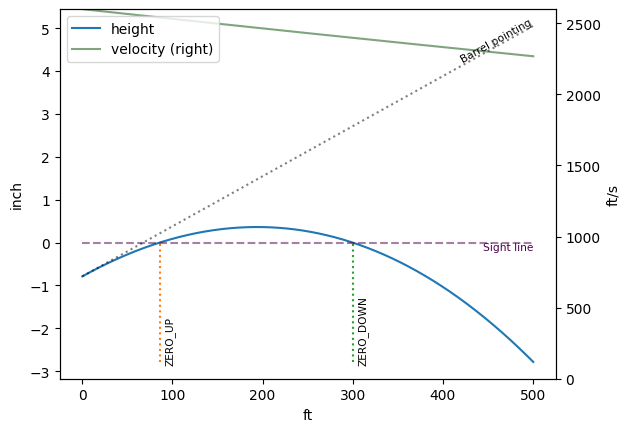

In [19]:
# Plot trajectory out to 500 yards
shot_result = calc.fire(zero, trajectory_range=500, extra_data=True)
ax = shot_result.plot()
# Find danger space for a half-meter tall target at 300 yards
danger_space = shot_result.danger_space(Distance.Yard(300), Distance.Meter(.5))
print(danger_space)
danger_space.overlay(ax)  # Highlight danger space on the plot
plt.show()

# Print Range Card

In [ ]:
# Range card for this zero with 5mph cross-wind from left to right
zero.winds = [Wind(Velocity.MPH(5), Angular.OClock(3))]
range_card = calc.fire(zero, trajectory_range=1000)
# for p in range_card: print(p.formatted())
range_card.dataframe().to_clipboard()
range_card.dataframe(True).drop(['height', 'look_distance', 'density_factor', 'energy', 'ogw', 'flag'], axis=1).set_index('distance')

# Firing Solutions

## Different Distance, from Range Card

First approach here shows getting firing solution by looking up the adjustment in the Range Card:

In [ ]:
# Now shooter is sighting a target at look-distance 500 yard (zero.look-angle):
new_target_distance = Distance.Yard(500)
# Get row for this distance from the range card
new_target = range_card.get_at_distance(new_target_distance)
print(f'Zero trajectory hits {new_target.target_drop << PreferredUnits.drop}'
      f' at {(new_target.distance << PreferredUnits.distance)}')

# Shooter looks up adjustment to hit new target:
hold = new_target.drop_adj  # << Firing solution

print(f'Sight adjustment to hit {(new_target.distance << PreferredUnits.distance)} target'
      f' is {(hold << PreferredUnits.adjustment)}')
# Shooter dials that hold value for a 500-yard shot.  Verification:
range_card.shot.relative_angle = Angular(-hold.unit_value, hold.units)
adjusted_result = calc.fire(range_card.shot, trajectory_range=1000)
trajectory_adjusted = adjusted_result.get_at_distance(new_target_distance)
print(f'After adjustment: drop at {trajectory_adjusted.distance << PreferredUnits.distance}'
      f' is {trajectory_adjusted.target_drop << PreferredUnits.drop}')

## Different Look Angle

Second approach here shows solving for barrel elevation to hit new target, then adjusting by the difference between that and the zero barrel elevation:

In [ ]:
# Calculate elevation for a new shot at a different look-angle
new_shot = copy.copy(zero)  # Copy the zero properties; NB: Not a deepcopy!
new_shot.look_angle = Angular.Degree(25.84)
new_elevation = calc.barrel_elevation_for_target(shot=new_shot, target_distance=new_target_distance)
# Firing solution:
hold = Angular.Mil((new_elevation >> Angular.Mil) - (zero.weapon.zero_elevation >> Angular.Mil))

print(f'To hit target at look-distance of {new_target_distance << PreferredUnits.distance}'
      f' sighted at a {new_shot.look_angle << PreferredUnits.angular} look-angle,' 
      f' barrel elevation={new_elevation << PreferredUnits.adjustment}')
print(f'Current zero has barrel elevated {zero.weapon.zero_elevation << PreferredUnits.adjustment}'
      f' so hold for new shot is {hold << PreferredUnits.adjustment}')      
horizontal = Distance(math.cos(new_shot.look_angle >> Angular.Radian)
                      * new_target_distance.unit_value, new_target_distance.units)
print(f'(Horizontal component of distance to this target is {horizontal})')

# Plot this shot
new_shot.relative_angle = hold
card = calc.fire(new_shot, trajectory_range=500)
card.dataframe(True).drop(['height', 'energy', 'ogw', 'drag', 'flag'], axis=1).set_index('distance')

# Complex example

Now we'll switch to metric units and:
* Define a standard .50BMG
* Enable and define Ammo model of powder temperature sensitivity.
* Zeroed for a distance of 500 meters, in a 5°C atmosphere at altitude 1000ft ASL.

In [ ]:
PreferredUnits.distance = Unit.Meter
PreferredUnits.velocity = Unit.MPS
PreferredUnits.drop = Unit.Meter
PreferredUnits.sight_height = Unit.Centimeter
Settings.USE_POWDER_SENSITIVITY = True

# Standard .50BMG
dm = DragModel(0.62, TableG1, 661, 0.51, 2.3)
ammo=Ammo(dm, 850, Temperature.Celsius(15))
ammo.calc_powder_sens(820, Temperature.Celsius(0))
weapon = Weapon(sight_height=9, twist=15)
atmo = Atmo(altitude=Distance.Foot(1000), temperature=Unit.Celsius(5), humidity=.5)
zero = Shot(weapon=weapon, ammo=ammo, atmo=atmo)
zero_distance = Distance.Meter(500)
calc = Calculator()
zero_elevation = calc.set_weapon_zero(zero, zero_distance)
print(f'Barrel elevation for {zero_distance} zero: {zero_elevation << PreferredUnits.adjustment}')
print(f'Muzzle velocity at zero temperature {atmo.temperature} is {ammo.get_velocity_for_temp(atmo.temperature) << PreferredUnits.velocity}')

In [ ]:
# Firing solution for 700m target at 30°
new_shot = copy.copy(zero)  # Copy the zero properties; NB: Not a deepcopy!
new_shot.look_angle = Angular.Degree(30)
new_target_distance = Distance.Meter(700)
new_elevation = calc.barrel_elevation_for_target(shot=new_shot, target_distance=new_target_distance)
horizontal = Distance(math.cos(new_shot.look_angle >> Angular.Radian)
                      * new_target_distance.unit_value, new_target_distance.units)
print(f'To hit target at look-distance of {new_target_distance << PreferredUnits.distance}'
      f' sighted at a {new_shot.look_angle << PreferredUnits.angular} look-angle,' 
      f' barrel elevation={new_elevation << PreferredUnits.adjustment}'
      f'\n\t(horizontal distance to this target is {horizontal})')

# Firing solution:
hold = Angular.Mil((new_elevation >> Angular.Mil) - (zero.weapon.zero_elevation >> Angular.Mil))
print(f'Current zero has barrel elevated {zero.weapon.zero_elevation << PreferredUnits.adjustment}'
      f' so hold for new shot is {hold << PreferredUnits.adjustment}')      

# Plot this shot
new_shot.relative_angle = hold
adjusted_result = calc.fire(new_shot, trajectory_range=1500, extra_data=True)
ax = adjusted_result.plot()
# Find danger space for a 4-meter tall target
danger_space = adjusted_result.danger_space(at_range=new_target_distance,
                                        target_height=Distance.Meter(4),
                                        look_angle=new_shot.look_angle)
print(danger_space)
# Highlight danger space on the plot
danger_space.overlay(ax, 'Danger Space\n(4m Target)')
plt.show()

## Multiple Winds

In [ ]:
new_shot.winds = [Wind(Velocity.MPS(4), Angular.OClock(9), until_distance=Distance.Meter(400)),
                  Wind(Velocity.MPS(4), Angular.OClock(3), until_distance=Distance.Meter(800)),
                  Wind(Velocity.MPS(4), Angular.OClock(9), until_distance=Distance.Meter(1200)),]
wind_result = calc.fire(new_shot, trajectory_range=1500, extra_data=True)
ax = wind_result.dataframe().plot(x='windage', y='distance', ylabel=f'Distance ({PreferredUnits.distance.key}s)', xlabel=f'Windage ({PreferredUnits.distance.key}s)', label='Deflection with winds')
no_wind = adjusted_result.dataframe()
ax.plot(no_wind.windage, no_wind.distance, label='No wind (spin drift only)')
plt.legend(loc="upper center")
plt.show()

# Plot Drag Curve

In [ ]:
df = pandas.DataFrame(TableG7)
ax = df.plot(x='Mach', y='CD', ylabel='Cd', legend=False)
plt.show()

# Multiple-BC
In the old days, even a G7 projectile like the 168gr .308 OTM was quoted with a G1 BC.  Then Sierra offered a multiple-BC model.  Later, Litz published a multiple-BC G7 model.  Here's how they compare.

In [ ]:
# Single G1 BC
dm1 = DragModelMultiBC([BCpoint(.462, Mach=1)], TableG1, weight=168, diameter=.308)
# Sierra's G1 BC: 0.462 above 2600 fps, 0.447 above 2100 fps, 0.424 above 1600 fps, and .405 below that.
dm2 = DragModelMultiBC([BCpoint(.462, V=Velocity.FPS(2600)), BCpoint(.462-(.462-.447)/2, V=Velocity.FPS(2350)), BCpoint(.424-(.424-.405)/2, V=Velocity.FPS(1850)), BCpoint(.405, V=Velocity.FPS(1600))],
                       TableG1, weight=168, diameter=.308)
# Single G7 BC
dm3 = DragModelMultiBC([BCpoint(.224, Mach=1)], TableG7, weight=168, diameter=.308)
# Litz's G7 multi-BC:
dm4 = DragModelMultiBC([BCpoint(.211, V=Velocity.FPS(1500)), BCpoint(.214, V=Velocity.FPS(2000)), BCpoint(.222, V=Velocity.FPS(2500)), BCpoint(.226, V=Velocity.FPS(3000))],
                       TableG7, weight=168, diameter=.308)
ax = pandas.DataFrame(dm1.drag_table).plot(x='Mach', y='CD', ylabel='Drag Coefficient', label='G1 Single BC (Baseline)')
pandas.DataFrame(dm2.drag_table).plot(x='Mach', y='CD', label='G1 Multiple BC (Sierra)', linestyle='dashed', linewidth=2, ax=ax)
pandas.DataFrame(dm3.drag_table).plot(x='Mach', y='CD', label='G7 Single BC', linestyle='dashdot', ax=ax)
pandas.DataFrame(dm4.drag_table).plot(x='Mach', y='CD', label='G7 Multiple BC (Litz)', linestyle='dotted', linewidth=3, ax=ax)
ax.spines[['right', 'top']].set_visible(False)
plt.show()

In [ ]:
PreferredUnits.distance = Unit.Yard
PreferredUnits.velocity = Unit.FPS
PreferredUnits.drop = Unit.Inch

for dm in [dm1, dm2, dm3, dm4]:
    zero = Shot(weapon=Weapon(sight_height=2), ammo=Ammo(dm, mv=Velocity.FPS(3000)))
    calc = Calculator()
    shot_result = calc.fire(zero, trajectory_range=1000, trajectory_step=500)
    display(shot_result.dataframe(True)[['distance', 'time', 'velocity', 'mach', 'target_drop', 'drag']].set_index('distance')[1:])

# Working With Units

In [ ]:
PreferredUnits.distance = Unit.Foot
print(f'Default distance unit: {PreferredUnits.distance.name}')
# Can create value in default unit with either float or another unit of same type
print(f'\tInstantiated from float (5): {PreferredUnits.distance(5)}')
print(f'\tInstantiated from Distance.Line(200): {PreferredUnits.distance(Distance.Line(200))}')

# Ways to define value in units
# 1. old syntax
unit_in_meter = Distance(100, Distance.Meter)
# 2. short syntax by Unit type class
unit_in_meter = Distance.Meter(100)
# 3. by Unit enum class
unit_in_meter = Unit.Meter(100)
print(f'100 meters: {unit_in_meter}')
# >>> 100 meters: 100.0m

# Convert unit
# 1. by .convert()
unit_in_yards = unit_in_meter.convert(Distance.Yard)
# 2. using shift syntax
unit_in_yards = unit_in_meter << Distance.Yard  # '<<=' operator also supports
print(f'100 meters in {unit_in_yards.units.key}: {unit_in_yards}')
# >>> 100 meters in yard: 109.4yd

# Get value in specified units (as float)
# 1. by .get_in()
value_in_km = unit_in_yards.get_in(Distance.Kilometer)
# 2. by shift syntax
value_in_km = unit_in_yards >> Distance.Kilometer  # '>>=' operator also supports
print(f'100 meters, value in km: {value_in_km}  (value type is {type(value_in_km)})')
# >>> 100 meters, value in km: 0.1  (value type is <class 'float'>)

# Getting unit raw value (a float)
rvalue = Distance.Meter(100).raw_value
rvalue = float(Distance.Meter(100))
print(f'100 meters in raw value: {rvalue}  (raw type is {type(rvalue)})')
# >>> 100 meters in raw value: 3937.0078740157483  (raw type is <class 'float'>)

# Comparison operators supported: < > <= >= == !=
print(f'Comparison: {unit_in_meter} == {Distance.Centimeter(100)}: {unit_in_meter == Distance.Centimeter(100)}')  # >>> False, compare two units by raw value
print(f'Comparison: {unit_in_meter} > .1*{unit_in_meter}: {unit_in_meter > .1*unit_in_meter.raw_value}')  # >>> True, compare unit with float by raw value